In [1]:
import itertools
from random import shuffle
import numpy as np

import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pylab as pl

from IPython import display
%matplotlib inline

## [Learning Generative Models with Sinkhorn Divergences](https://arxiv.org/abs/1706.00292)
### by Aude Genevay, Gabriel Peyré, and Marco Cuturi

This paper proposes the *Sinkhorn divergence*, an optimal transport (OT) based optimization objective amenable to auto-differentiation.  

### 0.  Data

Throughout this notebook, we'll use data drawn from a Gaussian Mixture Model (GMM).  Here is a function to draw samples from a GMM...

In [2]:
# Draw sample from mixture model
# k ~ Mult(pi)
# z ~ f_k
def draw_samples(pi_arr, mu_arr, cov_arr, n_samples=100):
    comp_arr = np.random.multinomial(n_samples, pi_arr)
    z = []
    y = []
    for idx, count in enumerate(comp_arr):
        for c in xrange(count):
            y.append(idx)
            z.append(np.random.multivariate_normal(mu_s[idx], cov_s[idx]))
    return np.array(z), np.array(y)[np.newaxis].T

def shuffle_in_unison_inplace(a, b):
    assert a.shape[0] == b.shape[0]
    p = np.random.permutation(a.shape[0])
    return a[p], b[p]

Let's generate some training data...

In [3]:
N = 300 # number of datapoints 
input_d = 2

# Define mixture model
pi = np.array([.35, .65])
mu_s = [np.array([-5., -5.]), np.array([5., 5.])]
cov_s = [np.array([[1., 0.], [0., 1.]]), np.array([[1., 0.], [0., 1.]])]

# draw_samples
X_train, y_train = draw_samples(pi, mu_s, cov_s, N)

# shuffle 
X_train, y_train = shuffle_in_unison_inplace(X_train,y_train)

In [4]:
def init_neural_net(layer_sizes, std=.001):
    # layer_sizes is a list of the input size, hidden layer sizes, and output size
    params = {'w':[], 'b':[]}
    for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:]):
        params['w'].append(tf.Variable(tf.random_normal([n_in, n_out], stddev=std)))
        params['b'].append(tf.Variable(tf.zeros([n_out,])))
    return params

def neural_net(X, params):
    h = [X]
    for w,b in zip(params['w'][:-1], params['b'][:-1]):
        h.append( tf.nn.relu( tf.matmul(h[-1], w) + b ) )
    # NOTE: no output activation.  TF will take care of this in pre-defined loss functions
    return tf.matmul(h[-1], params['w'][-1]) + params['b'][-1]

Now let's define a neural network instead of a regression model...

Let's set up the network's symbolic output and cost like we did for regression before...

### 3.  Generative Adversarial Network (GAN)
Now let's explore [Generative Adversarial Networks (GANs)](https://arxiv.org/abs/1406.2661) with TensorFlow.  GANs are composed of two neural networks.  One network is trying to classify simulated data from the real data.  The other network is trying to simulate data in such a way that the first net will be fooled.  The result of this process is that the second net gets better and better at simulating realistic data until eventually that data is indistinguishable from the real data.  The computational pipeline is summarized in the diagram below: 
![GAN_pipeline](./graphics/GAN.png)  GANs are refered to as 'implicit generative models' as there is an implied likelihood but not a well-specified one.

Now let's create the symbolic variables again.  This time we need another one, Z, that will be the samples drawn from the generator's latent space...

In [5]:
batch_size = 100
latent_d = 50 # z ~ p(z), GAN prior
hidden_d = 500 # num. of hidden units in NN

### Make symbolic variables
X = tf.placeholder("float", [None, input_d]) # samples to discriminate
Z = tf.placeholder("float", [None, latent_d]) # samples from generator's latent space

In [18]:
#def cost(X, Y):
#    return tf.reduce_sum((X - Y)**2, keep_dims=True)

def sinkhorn_loss(X, Y, epsilon=.05, L=10):
    
    X_new = tf.expand_dims(X, 1)
    Y_new = tf.expand_dims(Y, 0)
    
    diff = X_new - Y_new
    c = tf.reduce_sum(diff**2, reduction_indices=-1)
    K = tf.exp(-c/epsilon) 
    
    a = tf.ones((tf.shape(Y)[0], 1))
    b = tf.ones((tf.shape(Y)[0], 1))
    for l in range(L):
        a = 1./(tf.matmul(K, b) + 1e-8)
        b = 1./(tf.matmul(tf.transpose(K), a) + 1e-8)
    
    return tf.matmul(tf.transpose(tf.matmul(tf.mul(K, c), b)), a)

Define the discriminator model...

Define the generator model...

In [19]:
generator_params = init_neural_net([latent_d, hidden_d, input_d])
generator_out = neural_net(Z, generator_params)

loss = tf.reduce_sum(2.*sinkhorn_loss(X, generator_out) - sinkhorn_loss(X, X) - sinkhorn_loss(generator_out, generator_out))

Let's train...

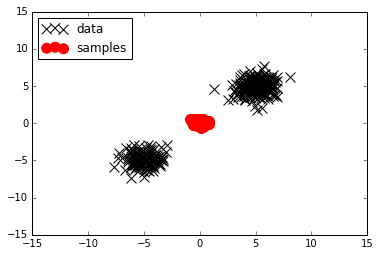

In [20]:
def plot_densities(true_data, samples):
    # clear the plot
    display.clear_output(wait=True)

    plt.scatter(true_data[:,0], true_data[:,1], s=100, color='k', marker='x', label="data")
    plt.scatter(samples[:,0], samples[:,1], s=100, color='r', marker='o', label="samples")
    plt.legend(loc=2)
    plt.xlim([-15,15])
    plt.ylim([-15,15])
    plt.show()


# Set training params
n_epochs = 350
learning_rate = 0.001

# create training ops
train_generator = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=generator_params['w']+generator_params['b'])

generator_weights = None
generator_biases = None
with tf.Session() as session:
    tf.initialize_all_variables().run()
    for epoch_idx in xrange(n_epochs):
        
        loss_tracker = 0.
        
        # train generator
        for idx in xrange(N/batch_size):
            # sample from generator again
            prior_samples = np.random.normal(size=(batch_size, latent_d))
        
            # perform update
            _, l = session.run([train_generator, loss], feed_dict={Z: prior_samples, X: X_train[idx*batch_size:(idx+1)*batch_size, :]})
            #print l
            #print
            loss_tracker += l
        
        # visualize progress
        if epoch_idx%5 == 0: 
            plot_densities(X_train, session.run(generator_out, feed_dict={Z: np.random.normal(size=(N/2, latent_d))}))

The GAN can capture one mode well but not both (at least for the settings I've tried).  This is known problem: "A common problem with GAN framework is that the generator tends to only generate samples that are clustered in one or a few modes of the regions of high data density, instead of spanning the whole range" [[source]](https://arxiv.org/pdf/1609.03126v2.pdf).

### 5.  Training a GAN on MNIST
Let's try to train a GAN on a subset of MNIST...

In [ ]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

# reduce dataset and normalize to [0,1]
random_idxs = range(mnist.data.shape[0])
shuffle(random_idxs)
mnist_images = mnist.data[random_idxs[:5000],:] / 255.

# show the first image
plt.imshow(np.reshape(mnist_images[0,:] * 255., (28, 28)), cmap='Greys_r')
plt.show()

Same symbolic variables, discriminator, and generator as before...

In [ ]:
N, input_d = mnist_images.shape
latent_d = 100 # z ~ p(z), GAN prior
hidden_d_discrim = 1000 # num. of hidden units in discrim NN
hidden_d_gen = 500 # num. of hidden units in gen NN

### Make symbolic variables
X = tf.placeholder("float", [None, input_d]) # samples to discriminate
Z = tf.placeholder("float", [None, latent_d]) # samples to discriminate
Y = tf.placeholder("float", [None, 1]) # labels

In [ ]:
discrim_params = init_neural_net([input_d, hidden_d_discrim, hidden_d_discrim, 1]) 
discrim_out = neural_net(X, discrim_params)
discrim_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(discrim_out, Y))

In [ ]:
generator_params = init_neural_net([latent_d, hidden_d_gen, input_d])
generator_out = neural_net(Z, generator_params)

# This line is new.  The images are on [0,1] so we need to apply a sigmoid to the samples.
generator_out_squashed = tf.nn.sigmoid(generator_out)

discrim_out_genUpdate = neural_net(generator_out_squashed, discrim_params)
generator_cost = tf.reduce_mean(-tf.nn.sigmoid_cross_entropy_with_logits(discrim_out_genUpdate, Y))

Train the GAN...

In [ ]:
# Make labels for training
X_true = mnist_images
Y_true = np.ones((N,1))
Y_gen = np.zeros((N,1))
Y_concat = np.vstack([Y_true, Y_gen])

# Set training params
n_epochs = 25
n_discrim_updates = 1
n_generator_updates = 1
d_learning_rate = .0002
g_learning_rate = .00005
batch_size = 120
n_batches = N/batch_size

# create training ops
train_discriminator = tf.train.AdamOptimizer(d_learning_rate).minimize(discrim_cost, var_list=discrim_params['w']+discrim_params['b'])
train_generator = tf.train.AdamOptimizer(g_learning_rate).minimize(generator_cost, var_list=generator_params['w']+generator_params['b'])

with tf.Session() as session:
    tf.initialize_all_variables().run()
    for epoch_idx in xrange(n_epochs):
        
        # train discriminator
        discrim_error = 0.
        for idx in xrange(n_discrim_updates):
            # sample from generator
            prior_samples = np.random.normal(size=(N, latent_d))
            genSamples = session.run(generator_out, feed_dict={Z: prior_samples})
        
            # make dataset and shuffle
            train_X = np.vstack([X_true, genSamples])
            train_X, train_Y = shuffle_in_unison_inplace(train_X, Y_concat)
        
            # perform batch updates
            epoch_discrim_error = 0.
            for batch_idx in xrange(n_batches):
                _, l = session.run([train_discriminator, discrim_cost], \
                                   feed_dict={X: train_X[batch_idx*batch_size:(batch_idx+1)*batch_size], \
                                              Y: train_Y[batch_idx*batch_size:(batch_idx+1)*batch_size]})
                epoch_discrim_error += l
            discrim_error += epoch_discrim_error/n_batches
            
        # print "Epoch %d.  Discriminator error: %.3f" %(epoch_idx, discrim_error)
        
        # train generator
        for idx in xrange(n_generator_updates):
            # sample from generator again
            prior_samples = np.random.normal(size=(N, latent_d))
        
            # perform batch updates
            for batch_idx in xrange(n_batches):
                session.run(train_generator, feed_dict={Z: prior_samples[batch_idx*batch_size:(batch_idx+1)*batch_size], \
                                                        Y: Y_gen[batch_idx*batch_size:(batch_idx+1)*batch_size]})
        
        # visualize a sample to gauge progress
        mnist_sample = session.run(generator_out_squashed, feed_dict={Z:np.random.normal(size=(1, latent_d))})
        display.clear_output(wait=True)
        plt.imshow(np.reshape(mnist_sample * 255., (28, 28)), cmap='Greys_r')
        plt.show()

There has been recent work on trying to understand what GANs are doing in terms of classic estimation principles.  See [Shakir Mohamed's note](https://arxiv.org/abs/1610.03483) characterizing GANs as performing ratio tests, $p(x)/q(x)$ where $p(x)$ is the true distribution and $q(x)$ is the simulated one.   